<a href="https://colab.research.google.com/github/LuisErnestoColchado/Learning-Deep-Pollution/blob/master/LSTM_LSTME_XGBOOST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
##
# title: Learning Deep Air Pollution
# description:
# start date: April 26, 2019
# author: Luis Ernesto Colchado Soncco
# email: luis.colchado@ucsp.edu.pe

In [0]:

# DL libraries
import tensorflow as tf

#LSTMED
from tensorflow.contrib import rnn
from tensorflow.python.ops import variable_scope
from tensorflow.python.framework import dtypes

# Data Manipulation
import numpy as np
import pandas as pd
import random
import math

# Files/OS
import os
import copy

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Error Analysis
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor

# ARIMA
from statsmodels.tsa.arima_model import ARIMA

scalar = MinMaxScaler((0,1))

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


   year  month  day  hour  pm2.5  DEWP  TEMP    PRES cbwd    Iws  Is  Ir
0  2010      1    1     0    NaN   -21 -11.0  1021.0   NW   1.79   0   0
1  2010      1    1     1    NaN   -21 -12.0  1020.0   NW   4.92   0   0
2  2010      1    1     2    NaN   -21 -11.0  1019.0   NW   6.71   0   0
3  2010      1    1     3    NaN   -21 -14.0  1019.0   NW   9.84   0   0
4  2010      1    1     4    NaN   -20 -12.0  1018.0   NW  12.97   0   0


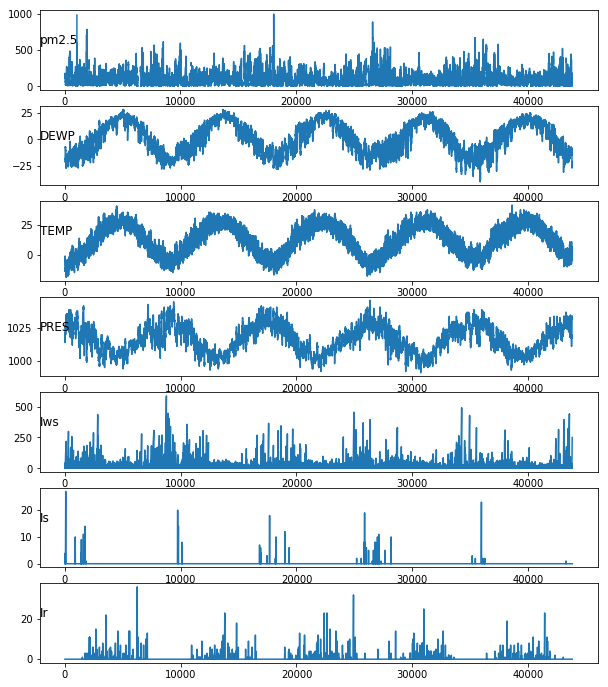

In [5]:
# READ DATA 2010 - 2014

df = pd.read_csv('/content/drive/My Drive/data.csv')
df = df.drop(columns=['No'])
print(df.head())

# PLOT EACH COLUMNS
cols_to_plot = ["pm2.5", "DEWP", "TEMP", "PRES", "Iws", "Is", "Ir"]
i = 1
plt.figure(figsize = (10,12))
for col in cols_to_plot:
    plt.subplot(len(cols_to_plot), 1, i)
    plt.plot(df[col])
    plt.title(col, y=0.5, loc='left')
    i += 1
plt.show()

   Unnamed: 0   dew  temp   press  wnd_dir  wnd_spd snow  rain  year  month  \
0           0 -20.4  -7.2  1034.9    340.0      1.0    0   0.0  2015      1   
1           1 -22.0  -5.0  1016.6     20.0      2.0    0  10.0  2015      1   
2           2 -22.0  -3.0  1016.6     30.0      3.0    0  10.0  2015      1   
3           3 -22.5  -1.2  1034.0    180.0      3.0    0  71.0  2015      1   
4           4 -22.0   0.0  1016.6    180.0      2.0    0  10.0  2015      1   

   day  hour  pollution  
0    1     0  14.644118  
1    1     1  16.429412  
2    1     2  18.444118  
3    1     3  15.455882  
4    1     4  15.773529  


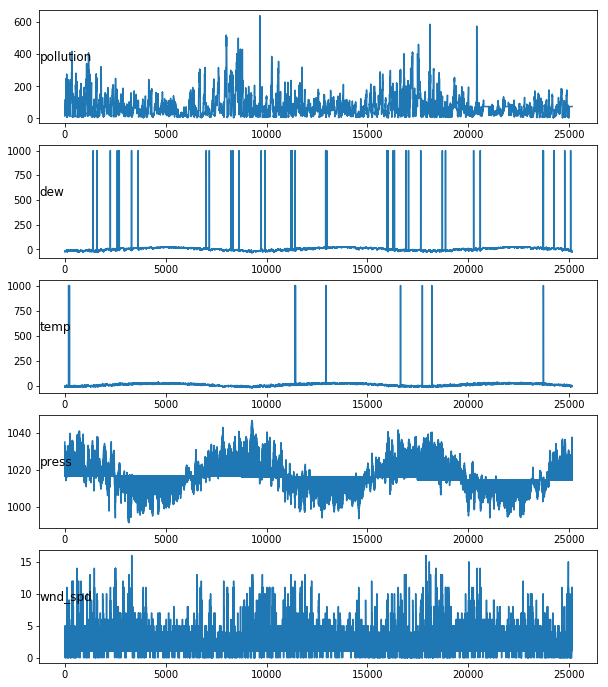

In [6]:
# READ DATA 2010 - 2014

df2 = pd.read_csv('/content/drive/My Drive/pollution_2015_2017.csv')
print(df2.head())

# PLOT EACH COLUMNS
cols_to_plot = ["pollution", "dew", "temp", "press", "wnd_spd"]
i = 1
plt.figure(figsize = (10,12))
for col in cols_to_plot:
    plt.subplot(len(cols_to_plot), 1, i)
    plt.plot(df2[col])
    plt.title(col, y=0.5, loc='left')
    i += 1
plt.show()

In [0]:
# PRE PROCESSING DATA

# NAN TO 0
df.fillna(0, inplace=True)

# ONE-HOT DIRECTION OF WIND
temp = pd.get_dummies(df['cbwd'], prefix='cbwd')
df = pd.concat([df, temp], axis = 1)
del df['cbwd'], temp

# ONE-HOT MONTH, DAY AND HOUR

temp = pd.get_dummies(df['month'], prefix='month')
df = pd.concat([df, temp], axis = 1)
del df['month'], temp

temp = pd.get_dummies(df['day'], prefix='day')
df = pd.concat([df, temp], axis = 1)
del df['day'], temp

temp = pd.get_dummies(df['hour'], prefix='hour')
df = pd.concat([df, temp], axis = 1)
del df['hour'], temp

In [0]:
# NAN TO 0
df2.fillna(0, inplace=True)

In [0]:
# DATA WITHOUT MONTH, DAY AND HOUR 2010 - 2014
data1 = df.loc[:, ['pm2.5', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'cbwd_NE', 'cbwd_NW', 'cbwd_SE', 'cbwd_cv']].values.copy()
# DATA WITH MONTH, DAY AND HOUR 2010 - 2014
data2 = df.loc[:, ['pm2.5', 'DEWP', 'TEMP', 'PRES', 'Iws']].values.copy()
# DATA 2015 - 2017
data3 = df2.loc[:, ["pollution", "dew", "temp", "press", "wnd_spd"]].values.copy()

In [10]:
print("shapes: ", data2.shape, data3.shape)

shapes:  (43824, 5) (25146, 5)


In [0]:
X = data2.copy()
Y = data2[:,0].reshape(data2.shape[0],1).copy()
Xtest2015 = data3.copy()
Ytest2015 = data3[:,0].reshape(data3.shape[0],1).copy()

In [0]:
## z-score transform x - not including those one-hot columns!
for i in range(0,X.shape[1]):
    currentFeature = X[:, i].reshape(X.shape[0],1)
    X[:, i] = scalar.fit_transform(currentFeature).reshape(X.shape[0])

In [0]:
## z-score transform y
Y = scalar.fit_transform(Y)

In [0]:
## z-score transform x - not including those one-hot columns!
for i in range(0,Xtest2015.shape[1]):
    currentFeature = Xtest2015[:, i].reshape(Xtest2015.shape[0],1)
    Xtest2015[:, i] = scalar.fit_transform(currentFeature).reshape(Xtest2015.shape[0])

In [0]:
## z-score transform y
Ytest2015 = scalar.fit_transform(Ytest2015)

In [16]:
print(Xtest2015.shape, Ytest2015.shape)

(25146, 5) (25146, 1)


In [17]:
print(Y)

[[0.        ]
 [0.        ]
 [0.        ]
 ...
 [0.01006036]
 [0.00804829]
 [0.01207243]]


In [18]:
print(X.shape, Y.shape)

(43824, 5) (43824, 1)


In [0]:
input_seq_len = 8
output_seq_len = 1

def generate_train_samples(x, y, batch_size=24, input_seq_len=input_seq_len,
                           output_seq_len=output_seq_len,replace=False):
    total_start_points = len(x) - input_seq_len - output_seq_len
    start_x_idx = np.random.choice(range(total_start_points), batch_size, replace=replace)

    input_batch_idxs = [list(range(i, i + input_seq_len)) for i in start_x_idx]
    input_seq = np.take(x, input_batch_idxs, axis=0)

    output_batch_idxs = [list(range(i + input_seq_len, i + input_seq_len + output_seq_len)) for i in start_x_idx]
    output_seq = np.take(y, output_batch_idxs, axis=0)

    return input_seq, output_seq  # in shape: (batch_size, time_steps, feature_dim)


def generate_test_samples(x, y, input_seq_len=input_seq_len, output_seq_len=output_seq_len):
    total_samples = x.shape[0]

    input_batch_idxs = [list(range(i, i + input_seq_len)) for i in
                        range((total_samples - input_seq_len - output_seq_len))]
    input_seq = np.take(x, input_batch_idxs, axis=0)

    output_batch_idxs = [list(range(i + input_seq_len, i + input_seq_len + output_seq_len)) for i in
                         range((total_samples - input_seq_len - output_seq_len))]
    output_seq = np.take(y, output_batch_idxs, axis=0)

    return input_seq, output_seq

In [0]:
def plot_test(final_preds_expand, test_y_expand):
    fig, ax = plt.subplots(figsize=(17,8))
    ax.set_title("Test Predictions vs. Real values")
    ax.plot(final_preds_expand, color = 'red', label = 'predicted')
    ax.plot(test_y_expand, color = 'blue', label = 'actual')
    plt.legend(loc="upper left")
    plt.show()

**LSTM**

---


TRAIN AND TEST: 2010 - 2014 - CROSS VALIDATION

In [31]:
# LSTM KERAS
from keras.models import Model, Sequential
from keras.layers import Dense, Input, concatenate
from keras.layers import LSTM
from keras.layers.core import Reshape


batch_size = 1000
kFolds = KFold(n_splits=5)
countCross = 1
mean_rmse_1 = 0 
for train, test in kFolds.split(X):
    xTrain = X[train,:]
    yTrain = Y[train,:]
    xTest = X[test,:]
    yTest = Y[test,:]
    print("------------- CROSS VALIDATION ", countCross, "---------")
    print("**********LTSMNN***********")
    xTrain, yTrain = generate_train_samples(xTrain, yTrain, xTrain.shape[0],replace=True)
    model = Sequential()
    model.add(LSTM(30, batch_input_shape=(batch_size,xTrain.shape[1],xTrain.shape[2]), return_sequences=True))
    model.add(LSTM(30, stateful=True))
    model.add(Dense(1,activation='sigmoid'))
    print(model.summary())
    model.compile(loss='mae', optimizer='adam')
    xTrain = xTrain[0:35000,:,:]
    yTrain = yTrain[0:35000,:,:]
    yTrain = np.reshape(yTrain,(35000,1))

    model.fit(xTrain, yTrain, epochs=50, batch_size=batch_size)

    test_x,_ = generate_test_samples(xTest,yTest)
    test_x = test_x[0:8000,:,:]
    yTest = yTest[0:8000,:]
    yhat = model.predict(test_x, batch_size=1000)

    yhat = np.reshape(yhat, (8000, 1))
    predictTest_1 = scalar.inverse_transform(yhat)
    yTestI_1 = scalar.inverse_transform(yTest)
    rmseTest = np.sqrt(mean_squared_error(yTestI_1, predictTest_1))
    print("RMSE ", rmseTest)
    mean_rmse_1 += rmseTest
    countCross += 1
mean_rmse_1 /= 5

------------- CROSS VALIDATION  1 ---------
**********LTSMNN***********
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_25 (LSTM)               (1000, 8, 30)             4320      
_________________________________________________________________
lstm_26 (LSTM)               (1000, 30)                7320      
_________________________________________________________________
dense_13 (Dense)             (1000, 1)                 31        
Total params: 11,671
Trainable params: 11,671
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
35000/35000 [==============================] - 4s 114us/step - loss: 0.1978
Epoch 2/50
35000/35000 [==============================] - 1s 23us/step - loss: 0.0678
Epoch 3/50
35000/35000 [==============================] - 1s 22us/step - loss: 0.0651
Epoch 4/50
35000/35000 [==============================] - 1s 23us/

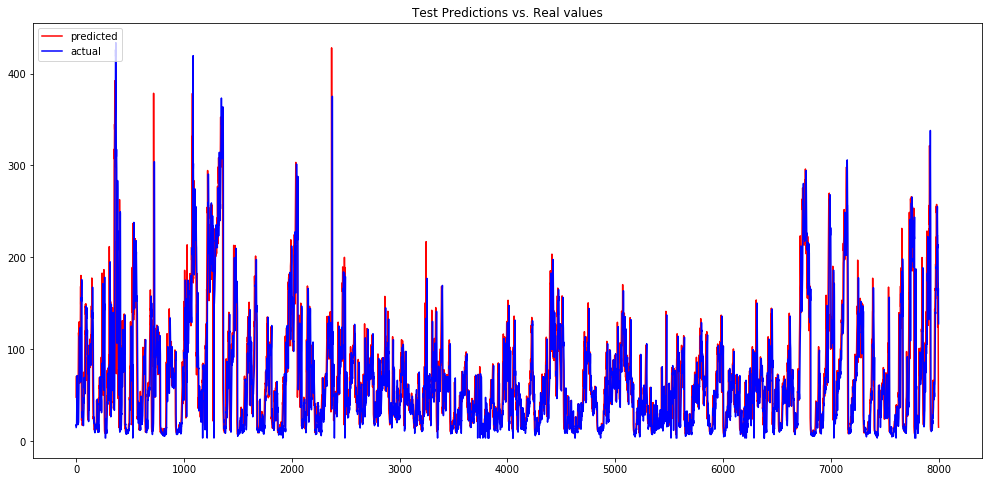

In [32]:
plot_test(predictTest_1, yTestI_1)

RMSE LSTM

DATABASE: 

TRAIN AND TEST:  2010 - 2014

In [33]:
print("MEAN RMSE CROSS VALIDATION: ", mean_rmse_1)

MEAN RMSE CROSS VALIDATION:  44.639590064453365




---



TRAIN: 2010 - 2014

TEST: 2015 - 2017


---



In [34]:
# LSTM KERAS
from keras.models import Model, Sequential
from keras.layers import Dense, Input, concatenate
from keras.layers import LSTM
from keras.layers.core import Reshape


batch_size = 1000

xTrain = X
yTrain = Y
xTest = Xtest2015
yTest = Ytest2015
print("**********LTSMNN***********")
xTrain, yTrain = generate_train_samples(xTrain, yTrain, xTrain.shape[0],replace=True)
model = Sequential()
model.add(LSTM(30, batch_input_shape=(batch_size,xTrain.shape[1],xTrain.shape[2]), return_sequences=True))
model.add(LSTM(30, stateful=True))
model.add(Dense(1,activation='sigmoid'))
print(model.summary())
model.compile(loss='mae', optimizer='adam')
xTrain = xTrain[0:43000,:,:]
yTrain = yTrain[0:43000,:,:]
yTrain = np.reshape(yTrain,(43000,1))

model.fit(xTrain, yTrain, epochs=100, batch_size=batch_size)

test_x,_ = generate_test_samples(xTest,yTest)
test_x = test_x[0:25000,:,:]
yTest = yTest[0:25000,:]
yhat = model.predict(test_x, batch_size=1000)

yhat = np.reshape(yhat, (25000, 1))
predictTest_2 = scalar.inverse_transform(yhat)
yTestI_2 = scalar.inverse_transform(yTest)
rmseTest_1 = np.sqrt(mean_squared_error(yTestI_2, predictTest_2))
print("RMSE ", rmseTest)

**********LTSMNN***********
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_35 (LSTM)               (1000, 8, 30)             4320      
_________________________________________________________________
lstm_36 (LSTM)               (1000, 30)                7320      
_________________________________________________________________
dense_18 (Dense)             (1000, 1)                 31        
Total params: 11,671
Trainable params: 11,671
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
43000/43000 [==============================] - 5s 116us/step - loss: 0.1611
Epoch 2/100
43000/43000 [==============================] - 1s 22us/step - loss: 0.0680
Epoch 3/100
43000/43000 [==============================] - 1s 23us/step - loss: 0.0653
Epoch 4/100
43000/43000 [==============================] - 1s 23us/step - loss: 0.0588
Epoch 5/100
43000/43

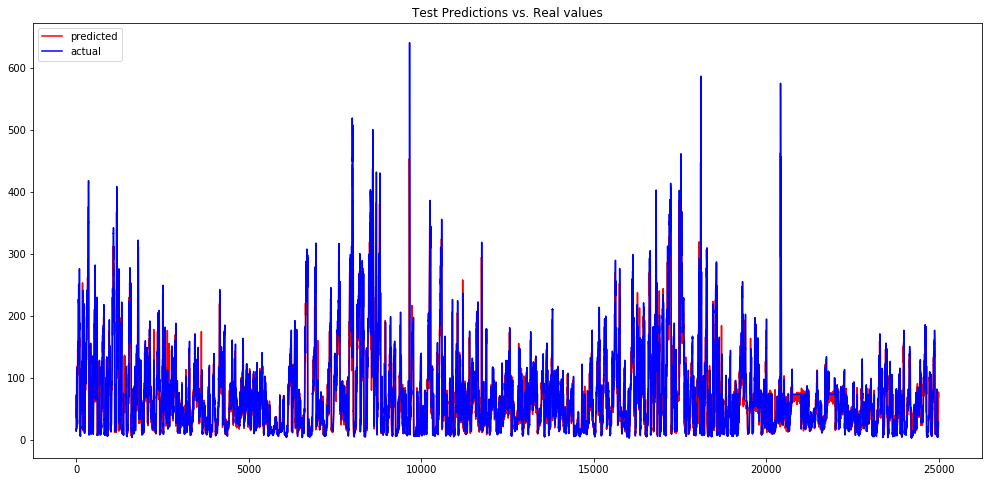

In [35]:
plot_test(predictTest_2, yTestI_2)

RMSE 

DATABASE:

  TRAIN: 2010 - 2014
  
  TEST: 2015 - 2017

In [37]:
print("RMSE: ", rmseTest_1)

RMSE:  44.45354267096251


LSTM ENCODER - DECODER 


---



In [0]:
# LSTM ENCODER: USE A LSTM FOR PROCESSING THE HISTORY DATA
learning_rate = 0.01
lambda_l2_reg = 0.003

# length of input signals
input_seq_len = input_seq_len
# length of output signals
output_seq_len = output_seq_len
# size of LSTM Cell
hidden_dim = 30
# num of input signals
input_dim = X.shape[1]
# num of output signals
output_dim = Y.shape[1]
# num of stacked lstm layers
num_stacked_layers = 2
# gradient clipping - to avoid gradient exploding
GRADIENT_CLIPPING = 2.5

In [0]:
def LSTMED(feed_previous=False):
    tf.reset_default_graph()

    global_step = tf.Variable(
        initial_value=0,
        name="global_step",
        trainable=False,
        collections=[tf.GraphKeys.GLOBAL_STEP, tf.GraphKeys.GLOBAL_VARIABLES])

    weights = {
        'out': tf.get_variable('Weights_out', \
                               shape=[hidden_dim, output_dim], \
                               dtype=tf.float32, \
                               initializer=tf.truncated_normal_initializer()),
    }
    biases = {
        'out': tf.get_variable('Biases_out', \
                               shape=[output_dim], \
                               dtype=tf.float32, \
                               initializer=tf.constant_initializer(0.)),
    }

    with tf.variable_scope('Seq2seq'):
        # Encoder: inputs
        enc_inp = [
            tf.placeholder(tf.float32, shape=(None, input_dim), name="inp_{}".format(t))
            for t in range(input_seq_len)
        ]

        # Decoder: target outputs
        target_seq = [
            tf.placeholder(tf.float32, shape=(None, output_dim), name="y".format(t))
            for t in range(output_seq_len)
        ]

        # Give a "GO" token to the decoder.
        # If dec_inp are fed into decoder as inputs, this is 'guided' training; otherwise only the
        # first element will be fed as decoder input which is then 'un-guided'
        dec_inp = [tf.zeros_like(target_seq[0], dtype=tf.float32, name="GO")] + target_seq[:-1]

        with tf.variable_scope('LSTMCell'):
            cells = []
            for i in range(num_stacked_layers):
                with tf.variable_scope('RNN_{}'.format(i)):
                    cells.append(tf.contrib.rnn.LSTMCell(hidden_dim))
            cell = tf.contrib.rnn.MultiRNNCell(cells)

        def _rnn_decoder(decoder_inputs,
                         initial_state,
                         cell,
                         loop_function=None,
                         scope=None):
            """RNN decoder for the sequence-to-sequence model.
            Args:
              decoder_inputs: A list of 2D Tensors [batch_size x input_size].
              initial_state: 2D Tensor with shape [batch_size x cell.state_size].
              cell: rnn_cell.RNNCell defining the cell function and size.
              loop_function: If not None, this function will be applied to the i-th output
                in order to generate the i+1-st input, and decoder_inputs will be ignored,
                except for the first element ("GO" symbol). This can be used for decoding,
                but also for training to emulate http://arxiv.org/abs/1506.03099.
                Signature -- loop_function(prev, i) = next
                  * prev is a 2D Tensor of shape [batch_size x output_size],
                  * i is an integer, the step number (when advanced control is needed),
                  * next is a 2D Tensor of shape [batch_size x input_size].
              scope: VariableScovpe for the created subgraph; defaults to "rnn_decoder".
            Returns:
              A tuple of the form (outputs, state), where:
                outputs: A list of the same length as decoder_inputs of 2D Tensors with
                  shape [batch_size x output_size] containing generated outputs.
                state: The state of each cell at the final time-step.
                  It is a 2D Tensor of shape [batch_size x cell.state_size].
                  (Note that in some cases, like basic RNN cell or GRU cell, outputs and
                   states can be the same. They are different for LSTM cells though.)
            """
            with variable_scope.variable_scope(scope or "rnn_decoder"):
                state = initial_state
                outputs = []
                prev = None
                for i, inp in enumerate(decoder_inputs):
                    if loop_function is not None and prev is not None:
                        with variable_scope.variable_scope("loop_function", reuse=True):
                            inp = loop_function(prev, i)
                    if i > 0:
                        variable_scope.get_variable_scope().reuse_variables()
                    output, state = cell(inp, state)
                    outputs.append(output)
                    if loop_function is not None:
                        prev = output
            return outputs, state

        def _basic_rnn_seq2seq(encoder_inputs,
                               decoder_inputs,
                               cell,
                               feed_previous,
                               dtype=dtypes.float32,
                               scope=None):
            """Basic RNN sequence-to-sequence model.
            This model first runs an RNN to encode encoder_inputs into a state vector,
            then runs decoder, initialized with the last encoder state, on decoder_inputs.
            Encoder and decoder use the same RNN cell type, but don't share parameters.
            Args:
              encoder_inputs: A list of 2D Tensors [batch_size x input_size].
              decoder_inputs: A list of 2D Tensors [batch_size x input_size].
              feed_previous: Boolean; if True, only the first of decoder_inputs will be
                used (the "GO" symbol), all other inputs will be generated by the previous
                decoder output using _loop_function below. If False, decoder_inputs are used
                as given (the standard decoder case).
              dtype: The dtype of the initial state of the RNN cell (default: tf.float32).
              scope: VariableScope for the created subgraph; default: "basic_rnn_seq2seq".
            Returns:
              A tuple of the form (outputs, state), where:
                outputs: A list of the same length as decoder_inputs of 2D Tensors with
                  shape [batch_size x output_size] containing the generated outputs.
                state: The state of each decoder cell in the final time-step.
                  It is a 2D Tensor of shape [batch_size x cell.state_size].
            """
            with variable_scope.variable_scope(scope or "basic_rnn_seq2seq"):
                enc_cell = copy.deepcopy(cell)
                _, enc_state = rnn.static_rnn(enc_cell, encoder_inputs, dtype=dtype)
                if feed_previous:
                    return _rnn_decoder(decoder_inputs, enc_state, cell, _loop_function)
                else:
                    return _rnn_decoder(decoder_inputs, enc_state, cell)

        def _loop_function(prev, _):
            '''Naive implementation of loop function for _rnn_decoder. Transform prev from
            dimension [batch_size x hidden_dim] to [batch_size x output_dim], which will be
            used as decoder input of next time step '''
            return tf.matmul(prev, weights['out']) + biases['out']

        dec_outputs, dec_memory = _basic_rnn_seq2seq(
            enc_inp,
            dec_inp,
            cell,
            feed_previous=feed_previous
        )

        reshaped_outputs = [tf.matmul(i, weights['out']) + biases['out'] for i in dec_outputs]

    # Training loss and optimizer
    with tf.variable_scope('Loss'):
        # L2 loss
        output_loss = 0
        for _y, _Y in zip(reshaped_outputs, target_seq):
            output_loss += tf.reduce_mean(tf.pow(_y - _Y, 2))

        # L2 regularization for weights and biases
        reg_loss = 0
        for tf_var in tf.trainable_variables():
            if 'Biases_' in tf_var.name or 'Weights_' in tf_var.name:
                reg_loss += tf.reduce_mean(tf.nn.l2_loss(tf_var))

        loss = output_loss + lambda_l2_reg * reg_loss

    with tf.variable_scope('Optimizer'):
        optimizer = tf.contrib.layers.optimize_loss(
            loss=loss,
            learning_rate=learning_rate,
            global_step=global_step,
            optimizer='Adam',
            clip_gradients=GRADIENT_CLIPPING)

    saver = tf.train.Saver

    return dict(
        enc_inp=enc_inp,
        target_seq=target_seq,
        train_op=optimizer,
        loss=loss,
        saver=saver,
        reshaped_outputs=reshaped_outputs,
    )

TRAIN AND TEST: 2010-2014

In [42]:
# CROSS VALIDATION - LSTMED
epochs = 100
# batch_size = 16
batch_size = 1000
KEEP_RATE = 0.5
kFolds = KFold(n_splits=5)
countCross = 1
mean_rmse_2 = 0 
for train, test in kFolds.split(X):
    xTrain = X[train,:]
    yTrain = Y[train,:]
    xTest = X[test,:]
    yTest = Y[test,:]
    print("CROSS VALIDATION ", countCross)
    # CREATE LIST FOR SAVE TRAINING AND VALIDATION LOSSES
    train_losses = []
    val_losses = []

    x = np.linspace(0, 40, 130)
    train_data_x = x[:110]

    rnn_model = LSTMED(feed_previous=False)

    init = tf.global_variables_initializer()
    with tf.Session() as sess:

        sess.run(init)

        print("Training losses: ")
        for i in range(epochs):
          for i in range (i,35):
            batch_input, batch_output = generate_train_samples(xTrain[i*1000:(i+1)*1000,:],yTrain[i*1000:(i+1)*1000,:],batch_size=batch_size, replace=True)

            feed_dict = {rnn_model['enc_inp'][t]: batch_input[:, t] for t in range(input_seq_len)}
            feed_dict.update({rnn_model['target_seq'][t]: batch_output[:, t] for t in range(output_seq_len)})
            _, loss_t = sess.run([rnn_model['train_op'], rnn_model['loss']], feed_dict)
          print(loss_t)

        temp_saver = rnn_model['saver']()
        save_path = temp_saver.save(sess, os.path.join('./', 'multivariate_ts_pollution_case'))

    print("Checkpoint saved at: ", save_path)

    test_x, test_y = generate_test_samples(xTest,yTest)
    rnn_model = LSTMED(feed_previous=True)

    init = tf.global_variables_initializer()
    with tf.Session() as sess:

        sess.run(init)

        saver = rnn_model['saver']().restore(sess, os.path.join('./', 'multivariate_ts_pollution_case'))

        feed_dict = {rnn_model['enc_inp'][t]: test_x[:, t, :] for t in range(input_seq_len)}  # batch prediction
        feed_dict.update({rnn_model['target_seq'][t]: np.zeros([test_x.shape[0], output_dim], dtype=np.float32) for t in
                          range(output_seq_len)})
        final_preds = sess.run(rnn_model['reshaped_outputs'], feed_dict)

        final_preds = [np.expand_dims(pred, 1) for pred in final_preds]
        final_preds = np.concatenate(final_preds, axis=1)
        inv_test_1 = scalar.inverse_transform(test_y.reshape(test_y.shape[0],1))
        inv_preds_1 = scalar.inverse_transform(final_preds.reshape(final_preds.shape[0],1))
        print("Test rmse is: ", np.sqrt(np.mean((inv_preds_1 - inv_test_1) ** 2)))
        mean_rmse_2 += np.sqrt(np.mean((inv_preds_1 - inv_test_1) ** 2))

mean_rmse_2 /= 5


CROSS VALIDATION  1
Training losses: 
0.03340869
0.02239
0.016858362
0.013432436
0.009271454
0.0069445283
0.00603773
0.00475771
0.0032897145
0.0027142633
0.0028925356
0.002184478
0.002237708
0.0019171254
0.0026604256
0.0018123342
0.0018045414
0.001638951
0.0021742398
0.0013604534
0.0013855889
0.0012789117
0.0015012333
0.0008456997
0.0012504024
0.0015280127
0.0021693113
0.0016925398
0.0012272734
0.0012955371
0.0014581765
0.0011436371
0.0012411758
0.0015364095
0.0013108298
0.0013108298
0.0013108298
0.0013108298
0.0013108298
0.0013108298
0.0013108298
0.0013108298
0.0013108298
0.0013108298
0.0013108298
0.0013108298
0.0013108298
0.0013108298
0.0013108298
0.0013108298
0.0013108298
0.0013108298
0.0013108298
0.0013108298
0.0013108298
0.0013108298
0.0013108298
0.0013108298
0.0013108298
0.0013108298
0.0013108298
0.0013108298
0.0013108298
0.0013108298
0.0013108298
0.0013108298
0.0013108298
0.0013108298
0.0013108298
0.0013108298
0.0013108298
0.0013108298
0.0013108298
0.0013108298
0.0013108298
0.00

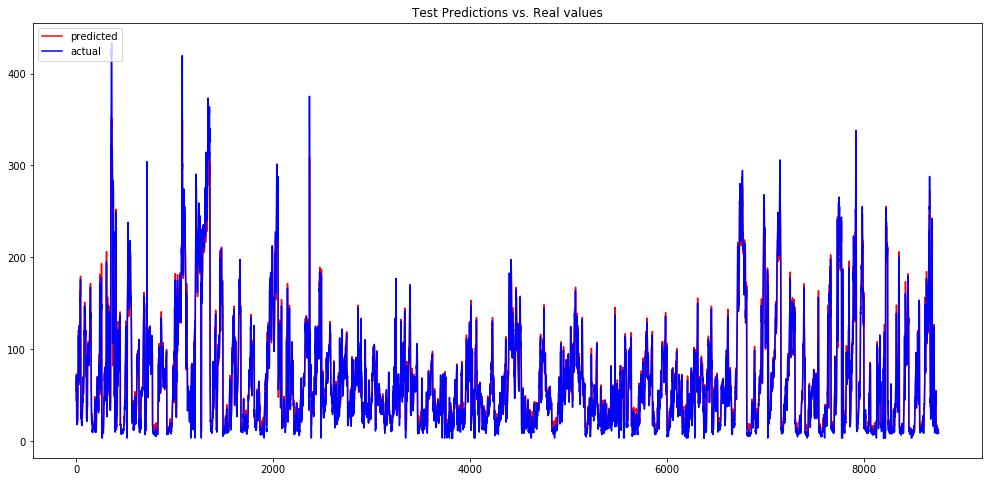

In [43]:
plot_test(inv_preds_1, inv_test_1)

RMSE LSTM ENCODER - DECODER

DATABASE: 

TRAIN AND TEST:  2010 - 2014

In [44]:
print("mean rmse cross validation: ", mean_rmse_2)

mean rmse cross validation:  18.04541992956539


TRAIN: 2010 - 2014

TEST: 2015 - 2017

In [45]:
xTrain = X
yTrain = Y
xTest = Xtest2015
yTest = Ytest2015
print("CROSS VALIDATION ", countCross)
# CREATE LIST FOR SAVE TRAINING AND VALIDATION LOSSES
train_losses = []
val_losses = []
x = np.linspace(0, 40, 130)
train_data_x = x[:110]

rnn_model = LSTMED(feed_previous=False)

init = tf.global_variables_initializer()
with tf.Session() as sess:

    sess.run(init)

    print("Training losses: ")
    for i in range(epochs):
      for i in range (i,43):
        batch_input, batch_output = generate_train_samples(xTrain[i*1000:(i+1)*1000,:],yTrain[i*1000:(i+1)*1000,:],batch_size=batch_size, replace=True)

        feed_dict = {rnn_model['enc_inp'][t]: batch_input[:, t] for t in range(input_seq_len)}
        feed_dict.update({rnn_model['target_seq'][t]: batch_output[:, t] for t in range(output_seq_len)})
        _, loss_t = sess.run([rnn_model['train_op'], rnn_model['loss']], feed_dict)
      print(loss_t)

    temp_saver = rnn_model['saver']()
    save_path = temp_saver.save(sess, os.path.join('./', 'multivariate_ts_pollution_case'))

print("Checkpoint saved at: ", save_path)

test_x, test_y = generate_test_samples(xTest,yTest)
rnn_model = LSTMED(feed_previous=True)

init = tf.global_variables_initializer()
with tf.Session() as sess:

    sess.run(init)

    saver = rnn_model['saver']().restore(sess, os.path.join('./', 'multivariate_ts_pollution_case'))

    feed_dict = {rnn_model['enc_inp'][t]: test_x[:, t, :] for t in range(input_seq_len)}  # batch prediction
    feed_dict.update({rnn_model['target_seq'][t]: np.zeros([test_x.shape[0], output_dim], dtype=np.float32) for t in
                      range(output_seq_len)})
    final_preds = sess.run(rnn_model['reshaped_outputs'], feed_dict)

    final_preds = [np.expand_dims(pred, 1) for pred in final_preds]
    final_preds = np.concatenate(final_preds, axis=1)
    inv_test = scalar.inverse_transform(test_y.reshape(test_y.shape[0],1))
    inv_preds = scalar.inverse_transform(final_preds.reshape(final_preds.shape[0],1))
    print("Test rmse is: ", np.sqrt(np.mean((inv_preds - inv_test) ** 2)))
    


CROSS VALIDATION  1
Training losses: 
0.026860634
0.014712844
0.009922848
0.0072824513
0.004689389
0.0033309043
0.0047041434
0.0024517933
0.0014650619
0.0019118014
0.0015626751
0.0008062797
0.0011580025
0.00082430465
0.0011964414
0.0026206807
0.0020912308
0.0010734735
0.0012362773
0.0006465582
0.0013907778
0.00087412115
0.0012003405
0.0009725677
0.0009954663
0.0011353476
0.0008792611
0.0010124453
0.00086523814
0.0007339204
0.0010559055
0.00082354
0.0008237312
0.00093926804
0.0016671125
0.0011027378
0.0013073836
0.0014116823
0.0008072381
0.0010905353
0.0009621072
0.0013245142
0.0012364085
0.0012364085
0.0012364085
0.0012364085
0.0012364085
0.0012364085
0.0012364085
0.0012364085
0.0012364085
0.0012364085
0.0012364085
0.0012364085
0.0012364085
0.0012364085
0.0012364085
0.0012364085
0.0012364085
0.0012364085
0.0012364085
0.0012364085
0.0012364085
0.0012364085
0.0012364085
0.0012364085
0.0012364085
0.0012364085
0.0012364085
0.0012364085
0.0012364085
0.0012364085
0.0012364085
0.0012364085
0.

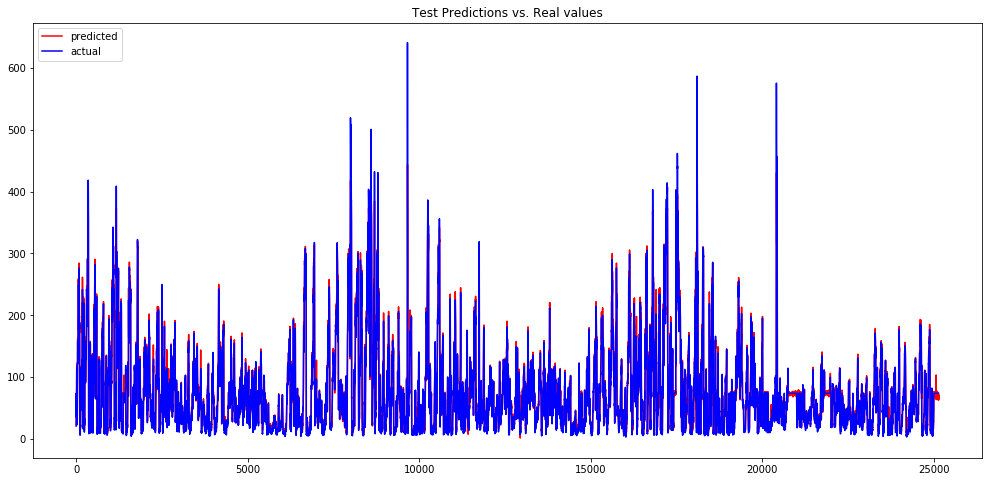

In [46]:
plot_test(inv_preds, inv_test)

RMSE LSTM ENCODER - DECODER

DATABASE: 

TRAIN: 2010 - 2014

TEST:  2015 - 2017

In [47]:
print("rmse: ", np.sqrt(np.mean((inv_preds - inv_test) ** 2)))

rmse:  12.424245992444783


XGBOOST

---




In [48]:
X.shape

(43824, 5)

In [0]:
xgb, ygb = generate_train_samples(X, Y, X.shape[0], replace=True)

In [50]:
print(xgb.shape, ygb.shape)

(43824, 8, 5) (43824, 1, 1)


In [0]:
Xxgboost = np.reshape(xgb,(X.shape[0], 40))
Yxgboost = np.reshape(ygb,(X.shape[0], 1))

In [52]:
print(Xxgboost[19,:])
print(Yxgboost[19,0])

[0.04325956 0.51470588 0.44262295 0.63636364 0.04891054 0.04124748
 0.57352941 0.44262295 0.63636364 0.05578057 0.04325956 0.60294118
 0.42622951 0.63636364 0.06799966 0.02816901 0.57352941 0.42622951
 0.61818182 0.006101   0.03521127 0.54411765 0.44262295 0.61818182
 0.006101   0.04024145 0.54411765 0.44262295 0.6        0.01297103
 0.04124748 0.54411765 0.44262295 0.58181818 0.01984107 0.05935614
 0.54411765 0.44262295 0.56363636 0.0267111 ]
0.057344064386317915


In [53]:
print(type(Xxgboost), Xxgboost.shape)

<class 'numpy.ndarray'> (43824, 40)


In [0]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [0]:
def xgboost(X_train, X_test, y_train, y_test):
  xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                  max_depth = 5, alpha = 10, n_estimators = 3000)
  xg_reg.fit(X_train,y_train)

  preds = xg_reg.predict(X_test)
  inv_pred = scalar.inverse_transform(np.reshape(preds, (1,-1)))
  inv_test = scalar.inverse_transform(np.reshape(y_test, (1,-1)))
  print("pred: ", inv_pred, "test: ", inv_test)
  rmse = np.sqrt(mean_squared_error(inv_test, inv_pred))
  print("RMSE: %f" % (rmse))
  return rmse

TRAIN AND TEST: 2010 - 2014

In [58]:
kFolds = KFold(n_splits=5)
countCross = 1
mean_rmse_3 = 0
for train, test in kFolds.split(Xxgboost):
    xTrain = Xxgboost[train,:]
    yTrain = Yxgboost[train,:]
    xTest = Xxgboost[test,:]
    yTest = Yxgboost[test,:]
    print("CROSS VALIDATION ", countCross)
    mean_rmse_3 += xgboost(xTrain, xTest, yTrain, yTest) 
    countCross += 1
mean_rmse_3 /= 5

CROSS VALIDATION  1
pred:  [[ 47.009724  50.297863  14.324689 ...  86.75298   50.780087 116.06277 ]] test:  [[ 50.27096074  48.34815791  18.86518124 ... 102.18663706  55.39843494
   95.13636003]]
RMSE: 11.721102
CROSS VALIDATION  2
pred:  [[19.871109 15.58704  36.067142 ... 15.728814 42.23794  53.31586 ]] test:  [[18.22424696 14.37864131 39.37507805 ... 10.53303565 45.14348653
  47.06628936]]
RMSE: 12.780304
CROSS VALIDATION  3
pred:  [[58.73921  65.64673  41.173775 ... 44.96041  17.63493  28.090803]] test:  [[34.88853813 58.60310632 47.70722364 ... 45.14348653  6.04649572
  29.12012964]]
RMSE: 12.936928
CROSS VALIDATION  4
pred:  [[43.285496 47.854214  9.856487 ... 53.489475 59.447563 16.762394]] test:  [[47.70722364 52.83469784  9.89210138 ... 65.65338335 65.01244908
  16.30144413]]
RMSE: 11.821461
CROSS VALIDATION  5
pred:  [[ 2.9592948 47.672985  43.772278  ... 78.13477   44.86259   48.55693  ]] test:  [[ 3.48275862 42.57974943 34.24760385 ... 80.39487169 26.55639254
  41.93881516]

RMSE XGBOOST

DATABASE: 

TRAIN AND TEST:  2010 - 2014

In [59]:
print("mean rmse cross validation: ", mean_rmse_3)

mean rmse cross validation:  12.222427408151194


----------------------------------------------------------------------------------------------------------------------------------------------------------------


TRAIN: 2010 - 2014

TEST: 20115 - 2017

In [60]:
print(X.shape, Xtest2015.shape, Y.shape, Ytest2015.shape)

(43824, 5) (25146, 5) (43824, 1) (25146, 1)


In [0]:
xtraingb, ytraingb = generate_train_samples(X, Y, X.shape[0], replace=True)
xtestgb, ytestgb = generate_train_samples(Xtest2015, Ytest2015, Xtest2015.shape[0], replace=True)

In [62]:
print(xtraingb.shape, ytraingb.shape, xtestgb.shape, ytestgb.shape)

(43824, 8, 5) (43824, 1, 1) (25146, 8, 5) (25146, 1, 1)


In [0]:
xtraingb = np.reshape(xtraingb,(xtraingb.shape[0], 40))
ytraingb = np.reshape(ytraingb,(ytraingb.shape[0], 1))
xtestgb = np.reshape(xtestgb,(xtestgb.shape[0], 40))
ytestgb = np.reshape(ytestgb,(ytestgb.shape[0], 1))

In [70]:
print("XGBOOST")
xgboost(xtraingb, xtestgb, ytraingb, ytestgb) 

XGBOOST
pred:  [[246.55223  105.161674 334.27753  ... 301.71237  190.187    158.04245 ]] test:  [[118.27272727  60.8        108.57575758 ...  93.62857143  97.88857143
   73.87217463]]
RMSE: 95.090379


95.09037916447036